<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [2]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as snsb
from copy import deepcopy

warnings.filterwarnings("ignore")

In [ ]:
pip install -r /content/requirements.txt

In [6]:
pip install etna

In [7]:
from etna.analysis import (
    cross_corr_plot,
    distribution_plot,
    acf_plot,
    plot_correlation_matrix,
)

from etna.transforms import LagTransform
from etna.datasets import TSDataset
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform
from etna.analysis import plot_imputation
from etna.analysis import plot_periodogram, stl_plot, seasonal_plot
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies
from etna.transforms import DensityOutliersTransform, TimeSeriesImputerTransform

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [8]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 5.92MB/s]                   


Взглянем на то, что представляют из себя данные:

In [9]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [10]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Я тут сразу сделаю задание 2, чтобы удобнее было визуализировать

In [11]:
tds_copy = df.copy(deep=True)
tds = pd.melt(tds_copy, id_vars='Date', value_vars=['CashOut', 'CashIn','target'])
tds.head()


Date variable    value
0  1/5/2016  CashOut -22200.0
1  1/6/2016  CashOut -18810.0
2  1/7/2016  CashOut -23210.0
3  1/8/2016  CashOut  -4350.0
4  1/9/2016  CashOut      NaN

In [12]:
tds["timestamp"] = pd.to_datetime(tds["Date"])
tds["target"] = tds["value"]
tds["segment"] = tds["variable"] 
tds.drop(columns=["Date",  'variable', 
                       'value'], inplace=True)

tds.head()

timestamp   target  segment
0 2016-01-05 -22200.0  CashOut
1 2016-01-06 -18810.0  CashOut
2 2016-01-07 -23210.0  CashOut
3 2016-01-08  -4350.0  CashOut
4 2016-01-09      NaN  CashOut

In [13]:
tsd_plots = TSDataset.to_dataset(tds)
ts_plots = TSDataset(tsd_plots, freq="1D")
ts_plots.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: 1D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
target        2016-01-05    2019-03-31    1182          110


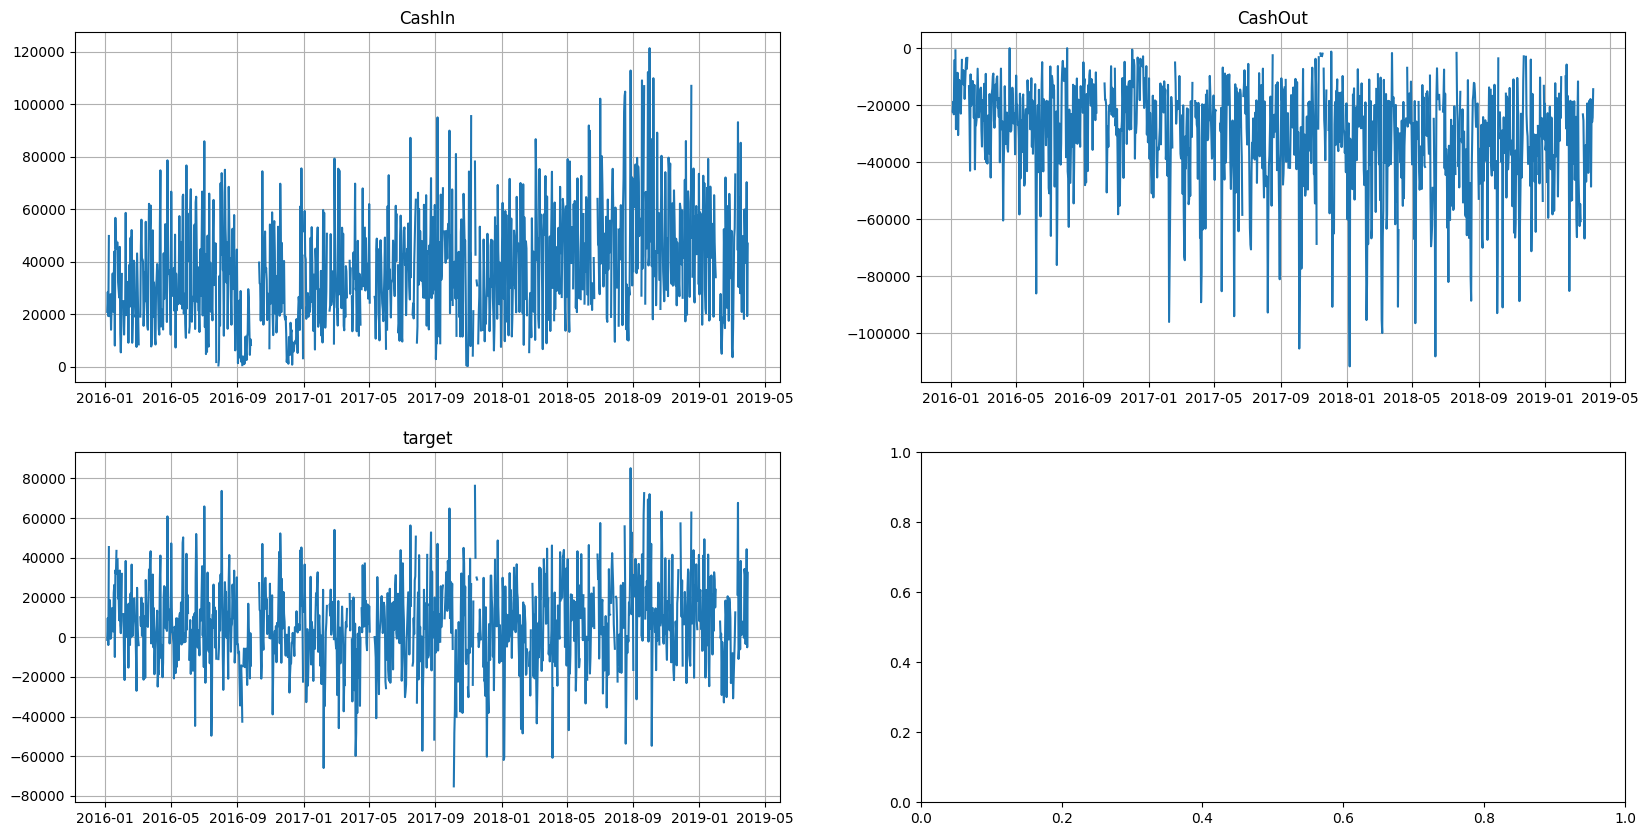

In [14]:
ts_plots.plot()

ох ох ох, сколько пропущенных то(((



не видно пока никакого тренда по балансу, но это же турция, вероятно пики изъятий и пополнений от инфляции..

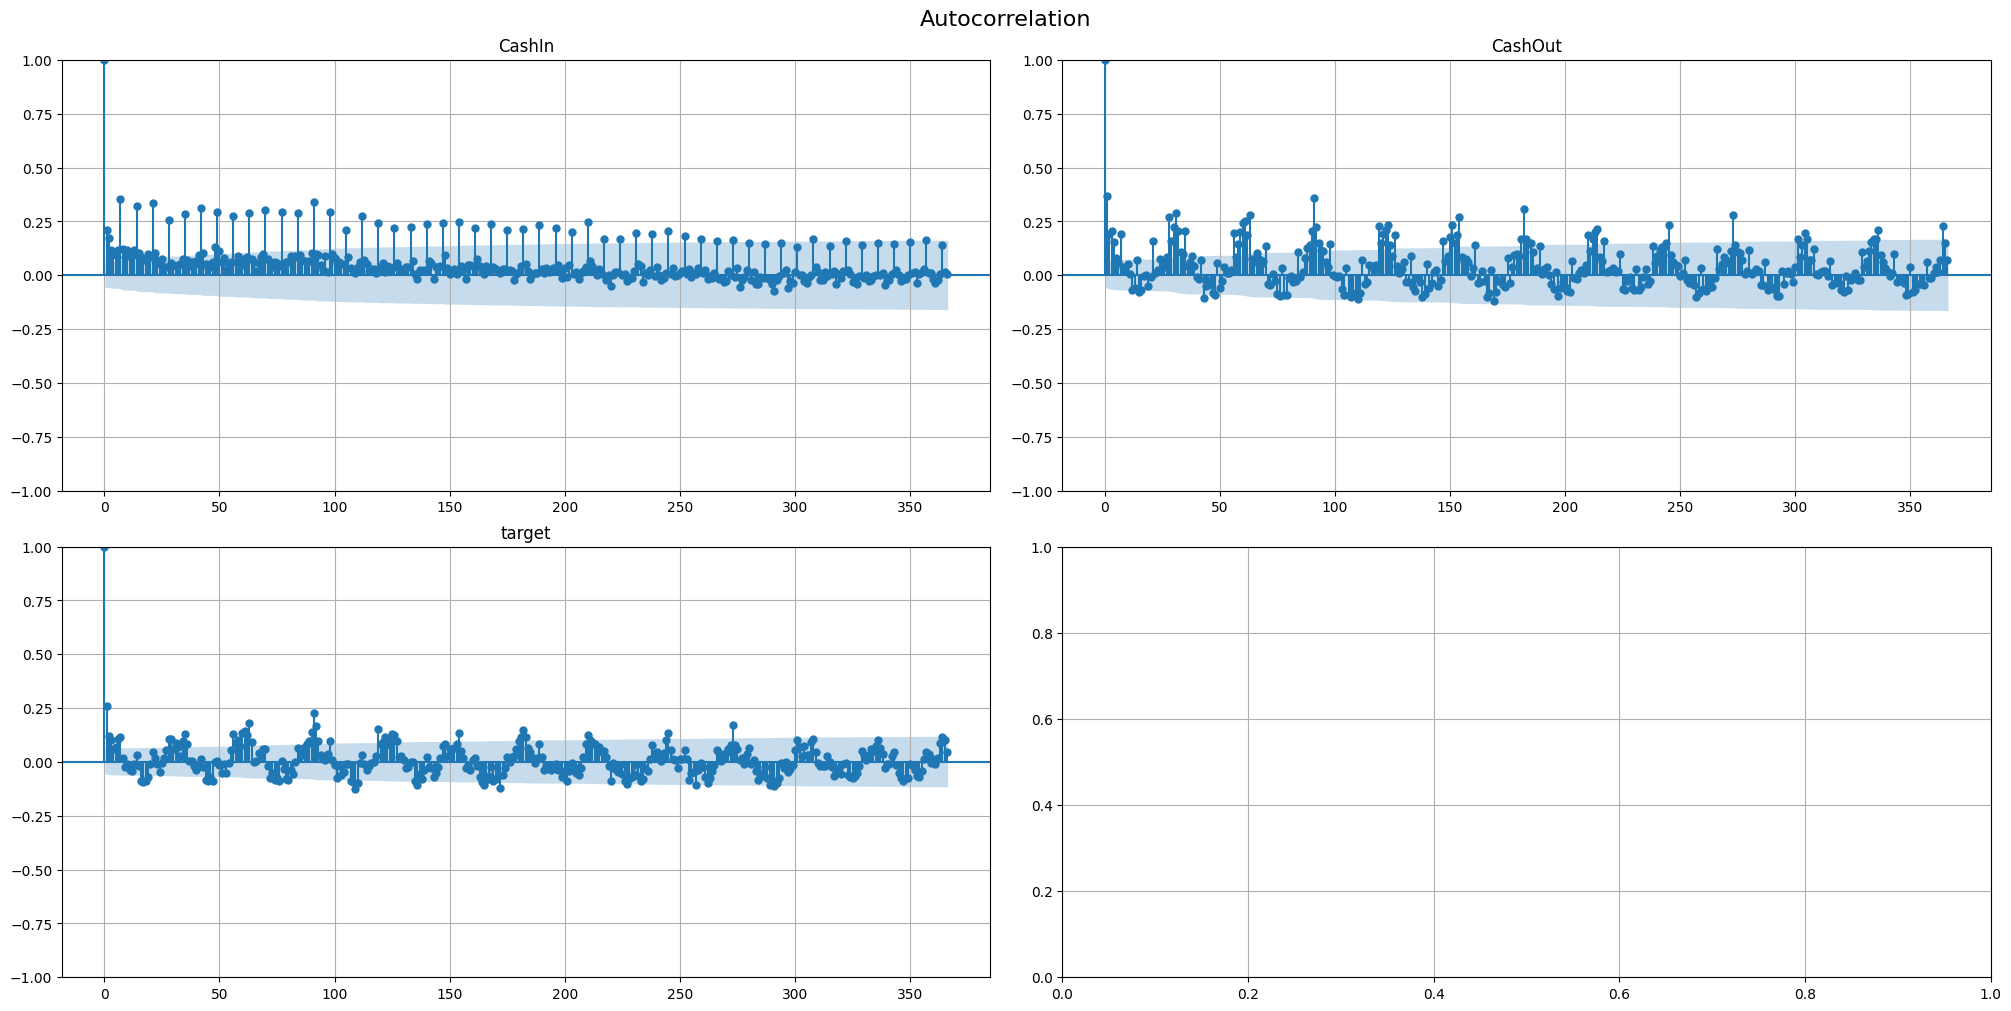

In [15]:
acf_plot(ts_plots, lags=366)

По ощущению - какая-то корреляция квартальная (то есть автоматом и годовая)сезонность

Частичную пока построить не можем, есть пропущенные значения внутри ряда - кажется больше всего корреляция с ближайшим лагом и квартальными лагами

In [16]:
lags = LagTransform(in_column="target",  lags=[1, 92, 182, 273,   364], out_column="lag")
ds_corr = TSDataset.to_dataset(tds)
tds_corr = TSDataset(ds_corr, freq="1D")

tds_corr.fit_transform([lags])

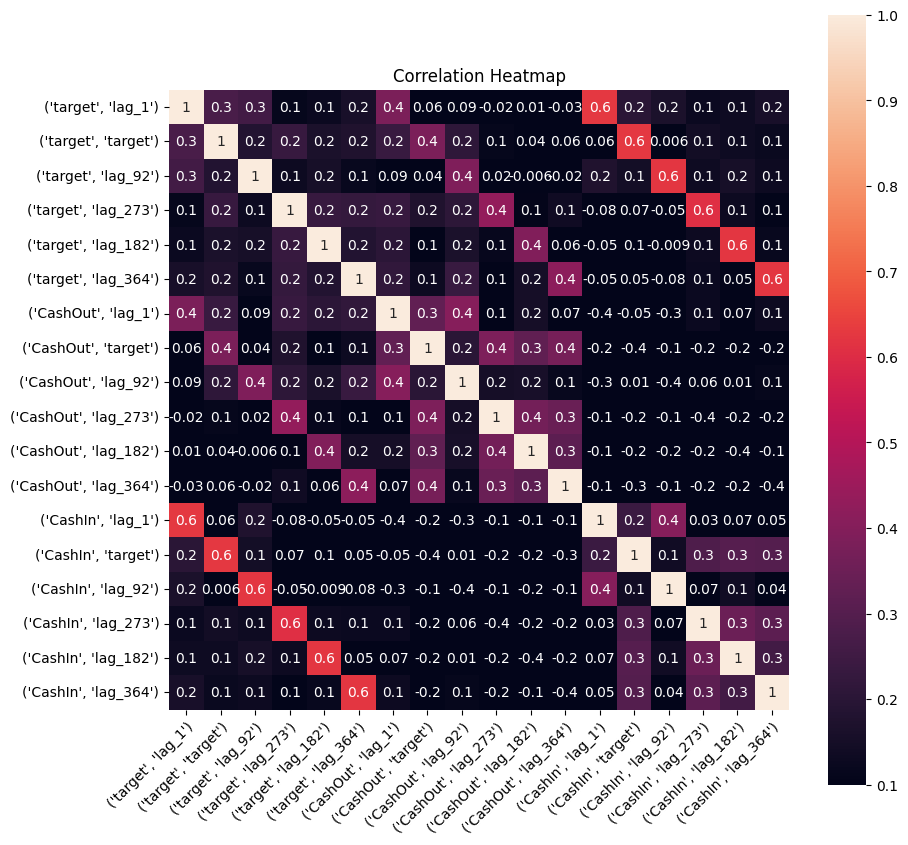

In [17]:
plot_correlation_matrix(tds_corr, segments=["target", "CashOut", 'CashIn'], method="spearman", vmin=0.1, vmax=1)

In [18]:
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]

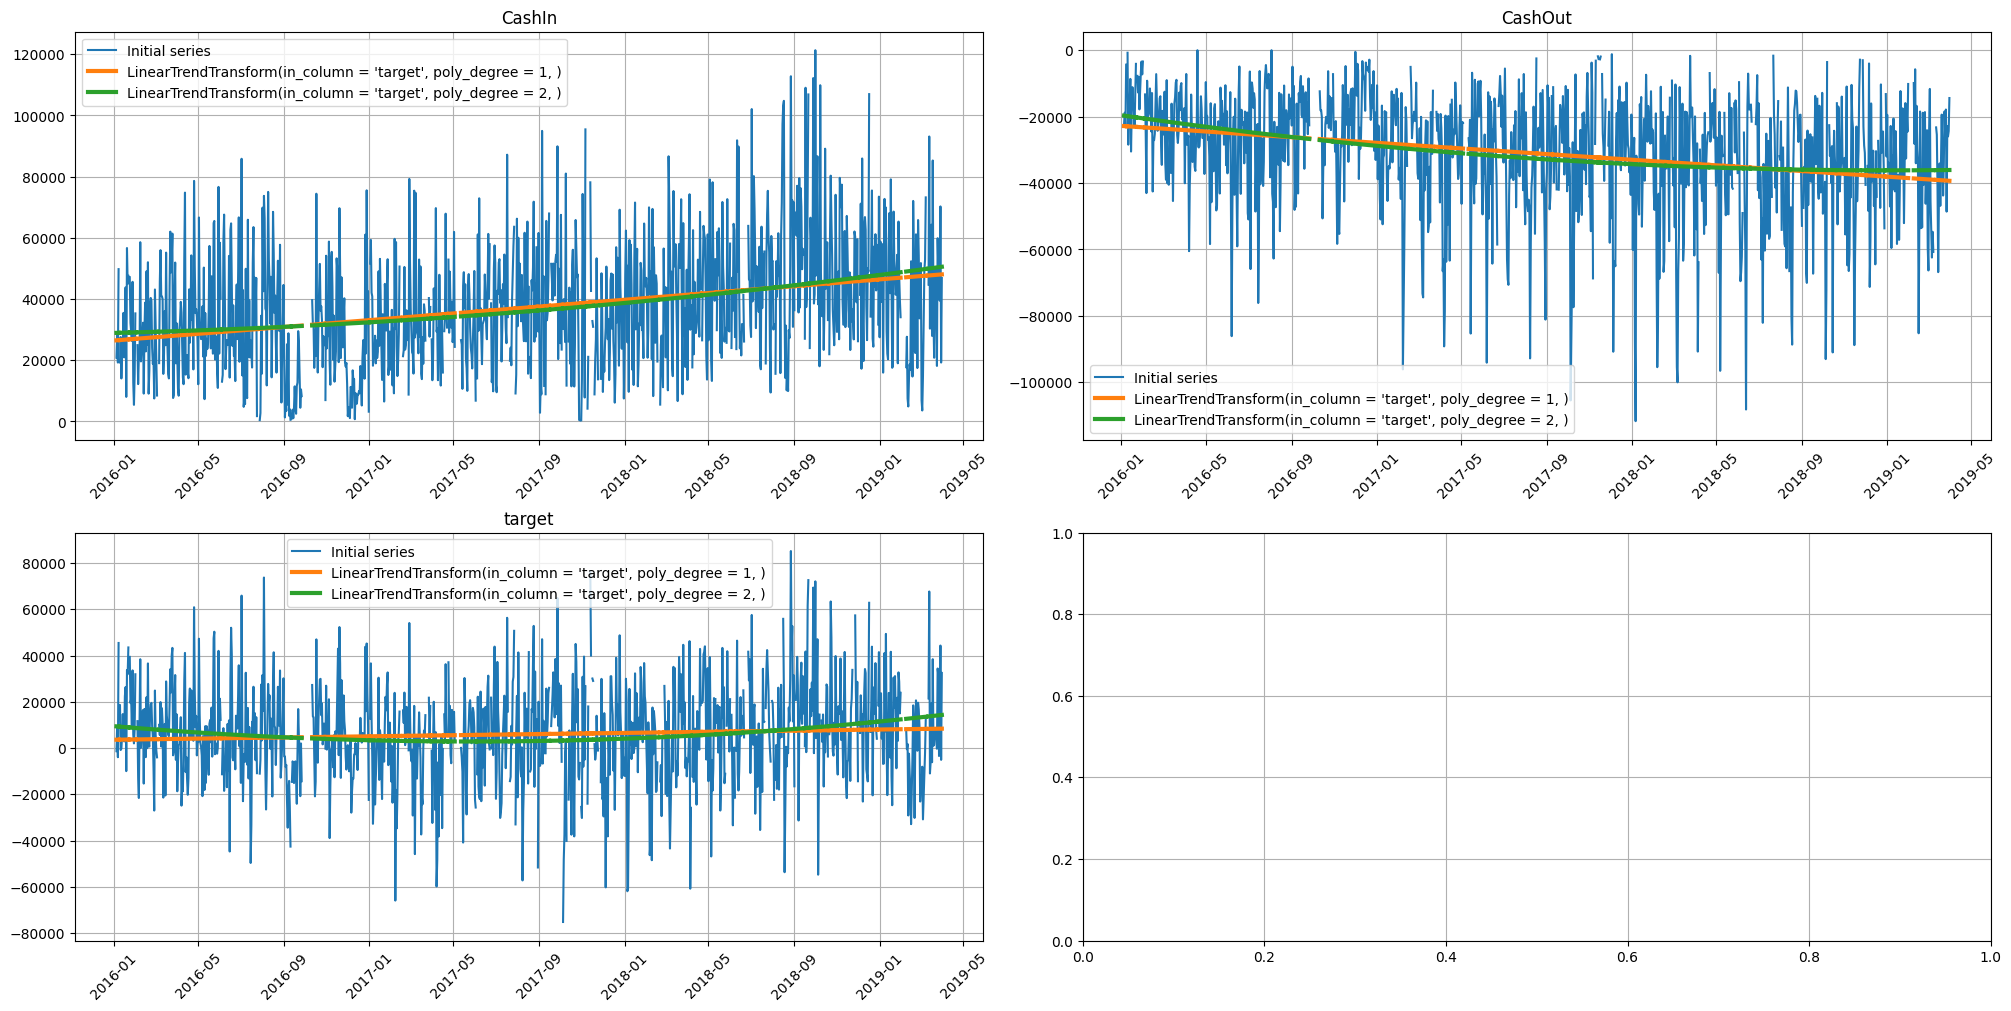

In [19]:
plot_trend(ts_plots, trend_transform=trends)

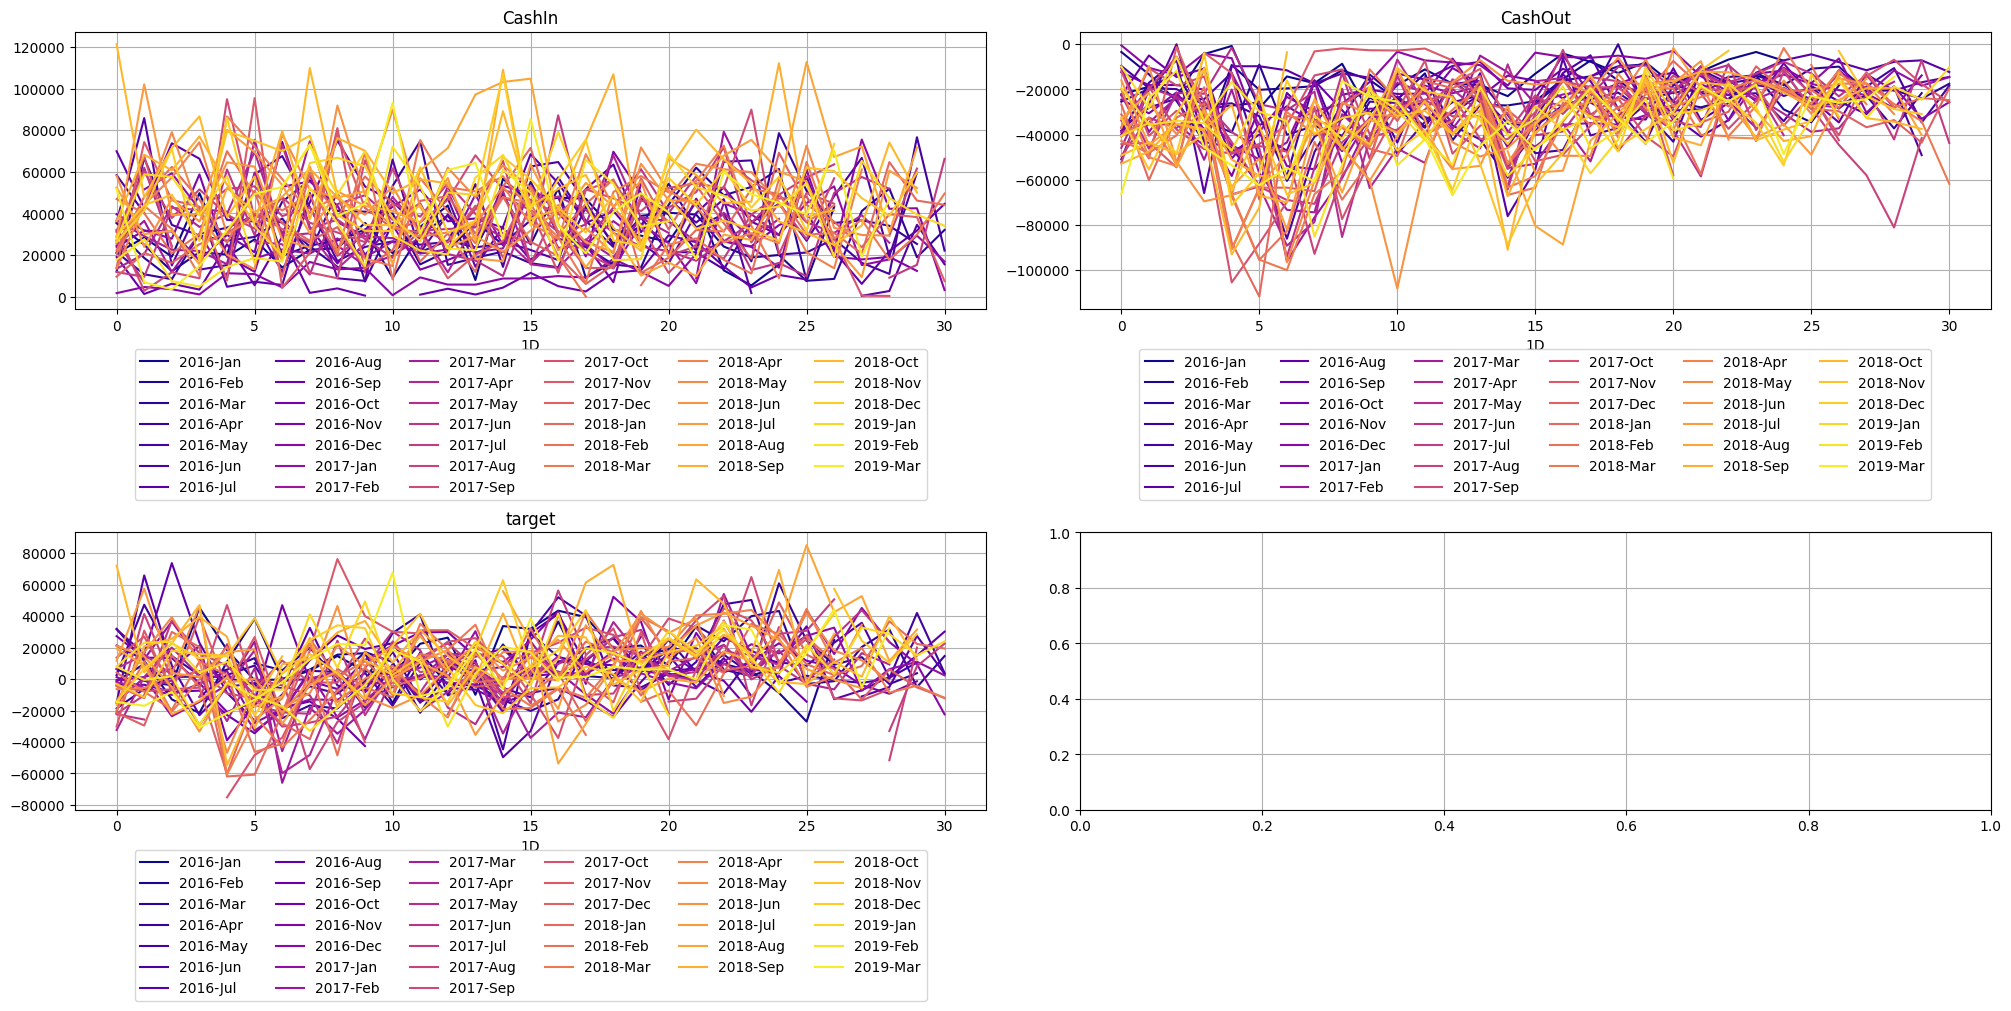

In [20]:
seasonal_plot(ts=ts_plots, cycle="month")

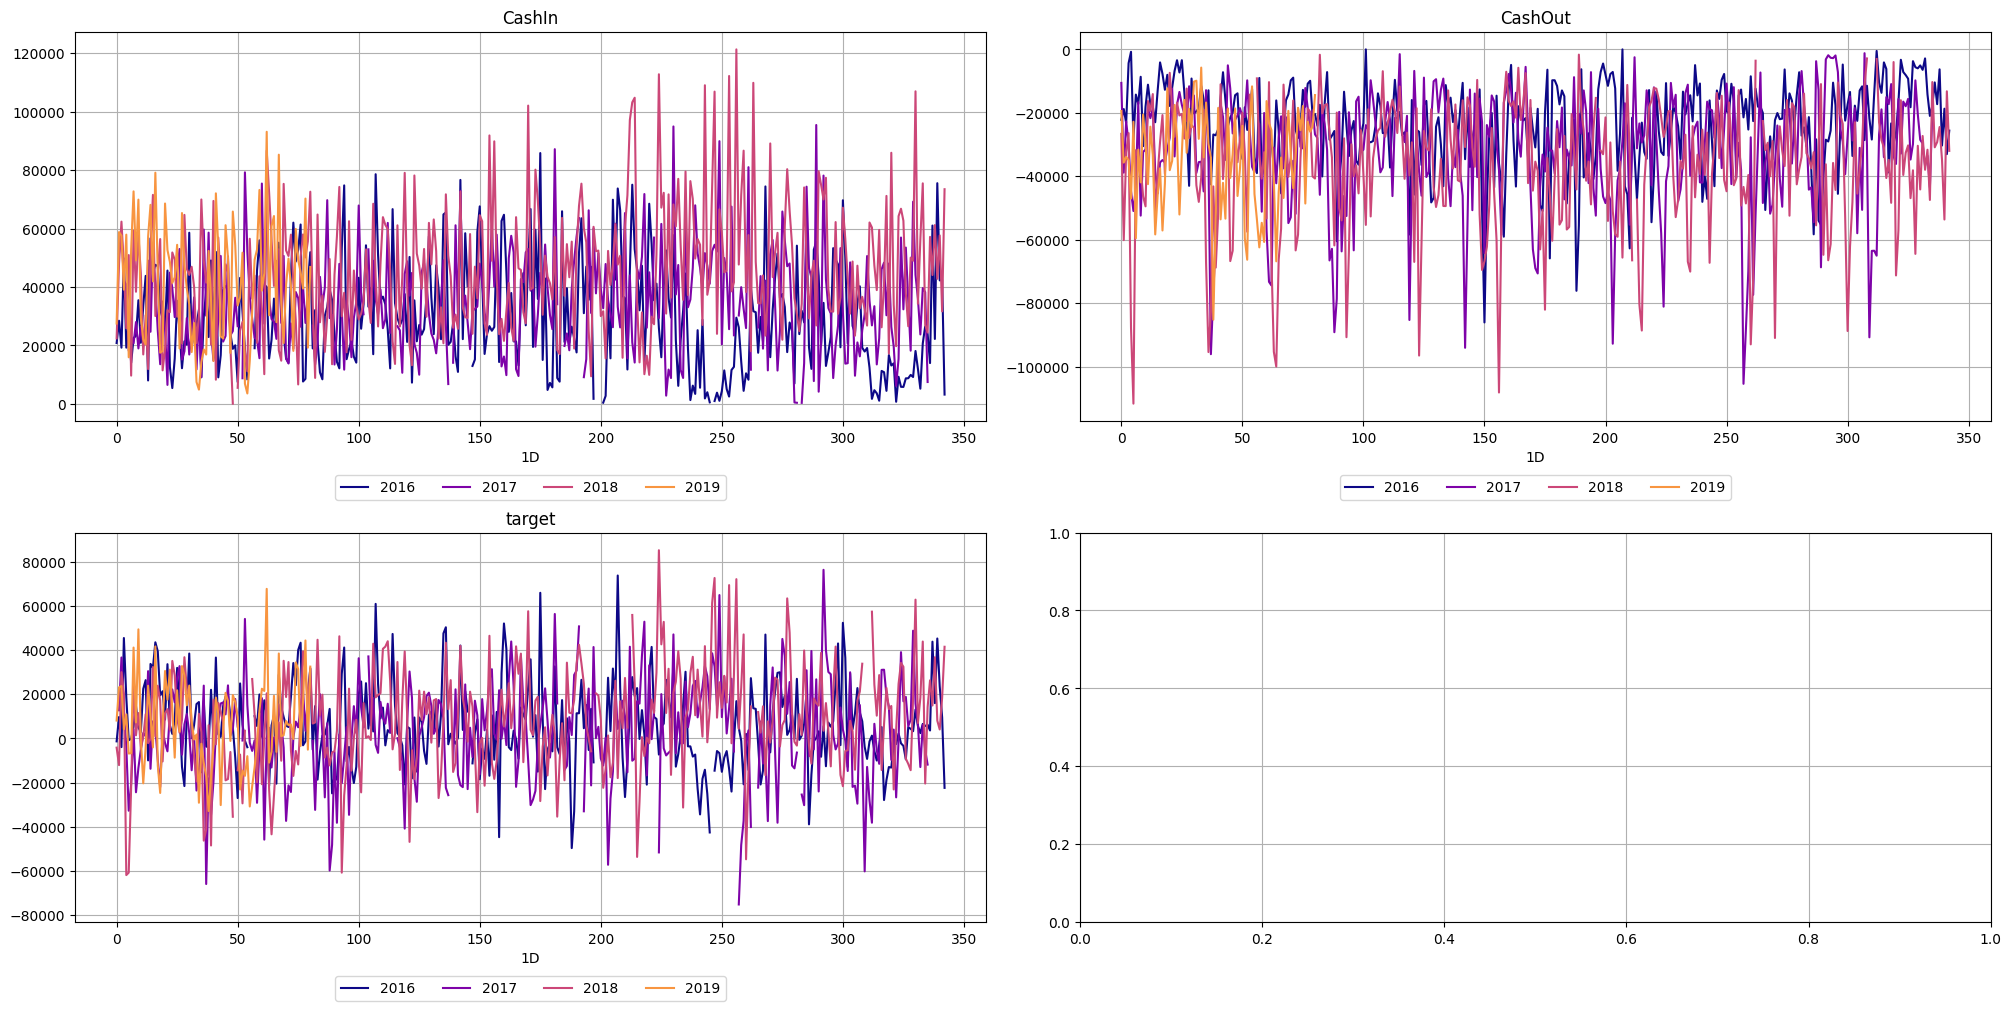

In [21]:
seasonal_plot(ts=ts_plots, cycle="year")

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

Сделано выше


In [22]:
ts_plots.head()

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [23]:
## пропущенные значения есть
ts_plots.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182          101             3   
CashOut       2016-01-05    2019-03-31    1182           88             3   
target        2016-01-05    2019-03-31    1182          110             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0   1D  
CashOut           0               0                 0   1D  
target            0               0                 0   1D

In [24]:
ds_copy = TSDataset.to_dataset(tds)
ts_copy = TSDataset(ds_copy, freq="1D")

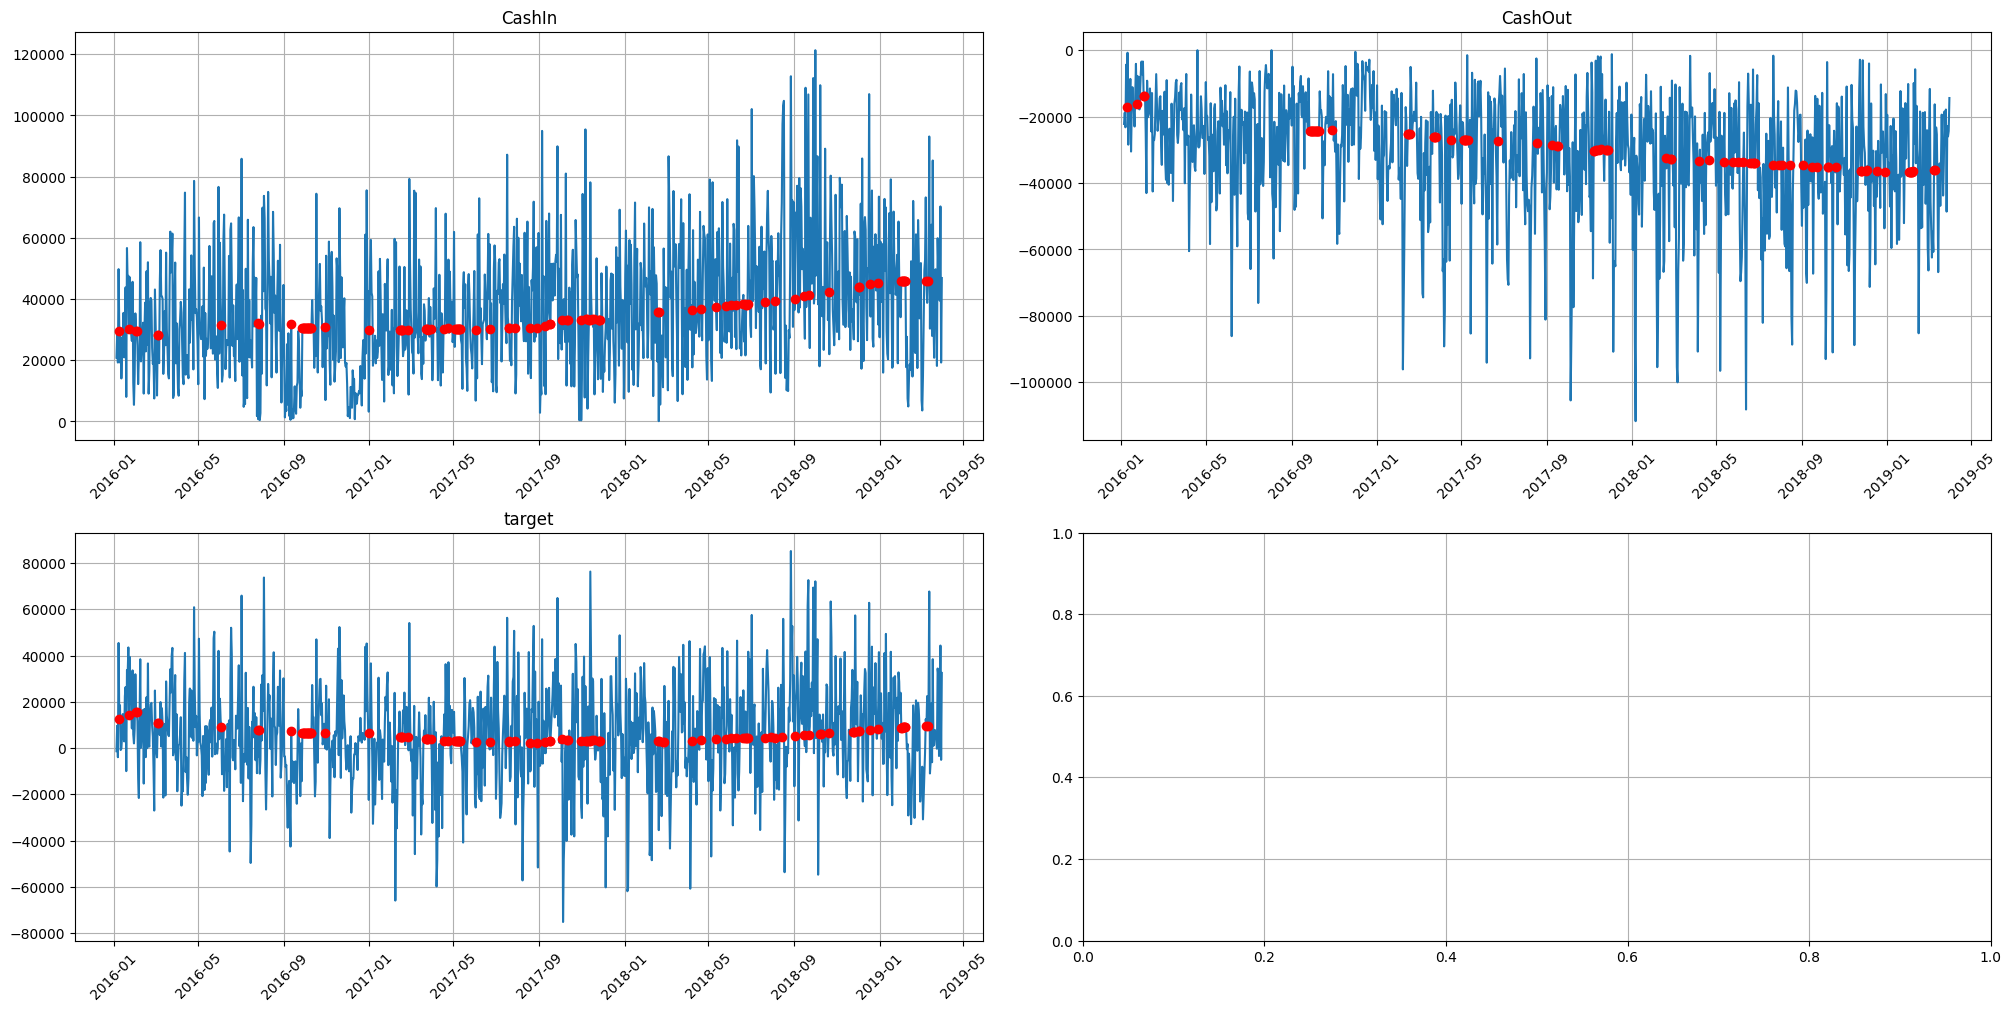

In [25]:
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="seasonal", window=365)
plot_imputation(imputer=outliers_imputer, ts=ts_copy)

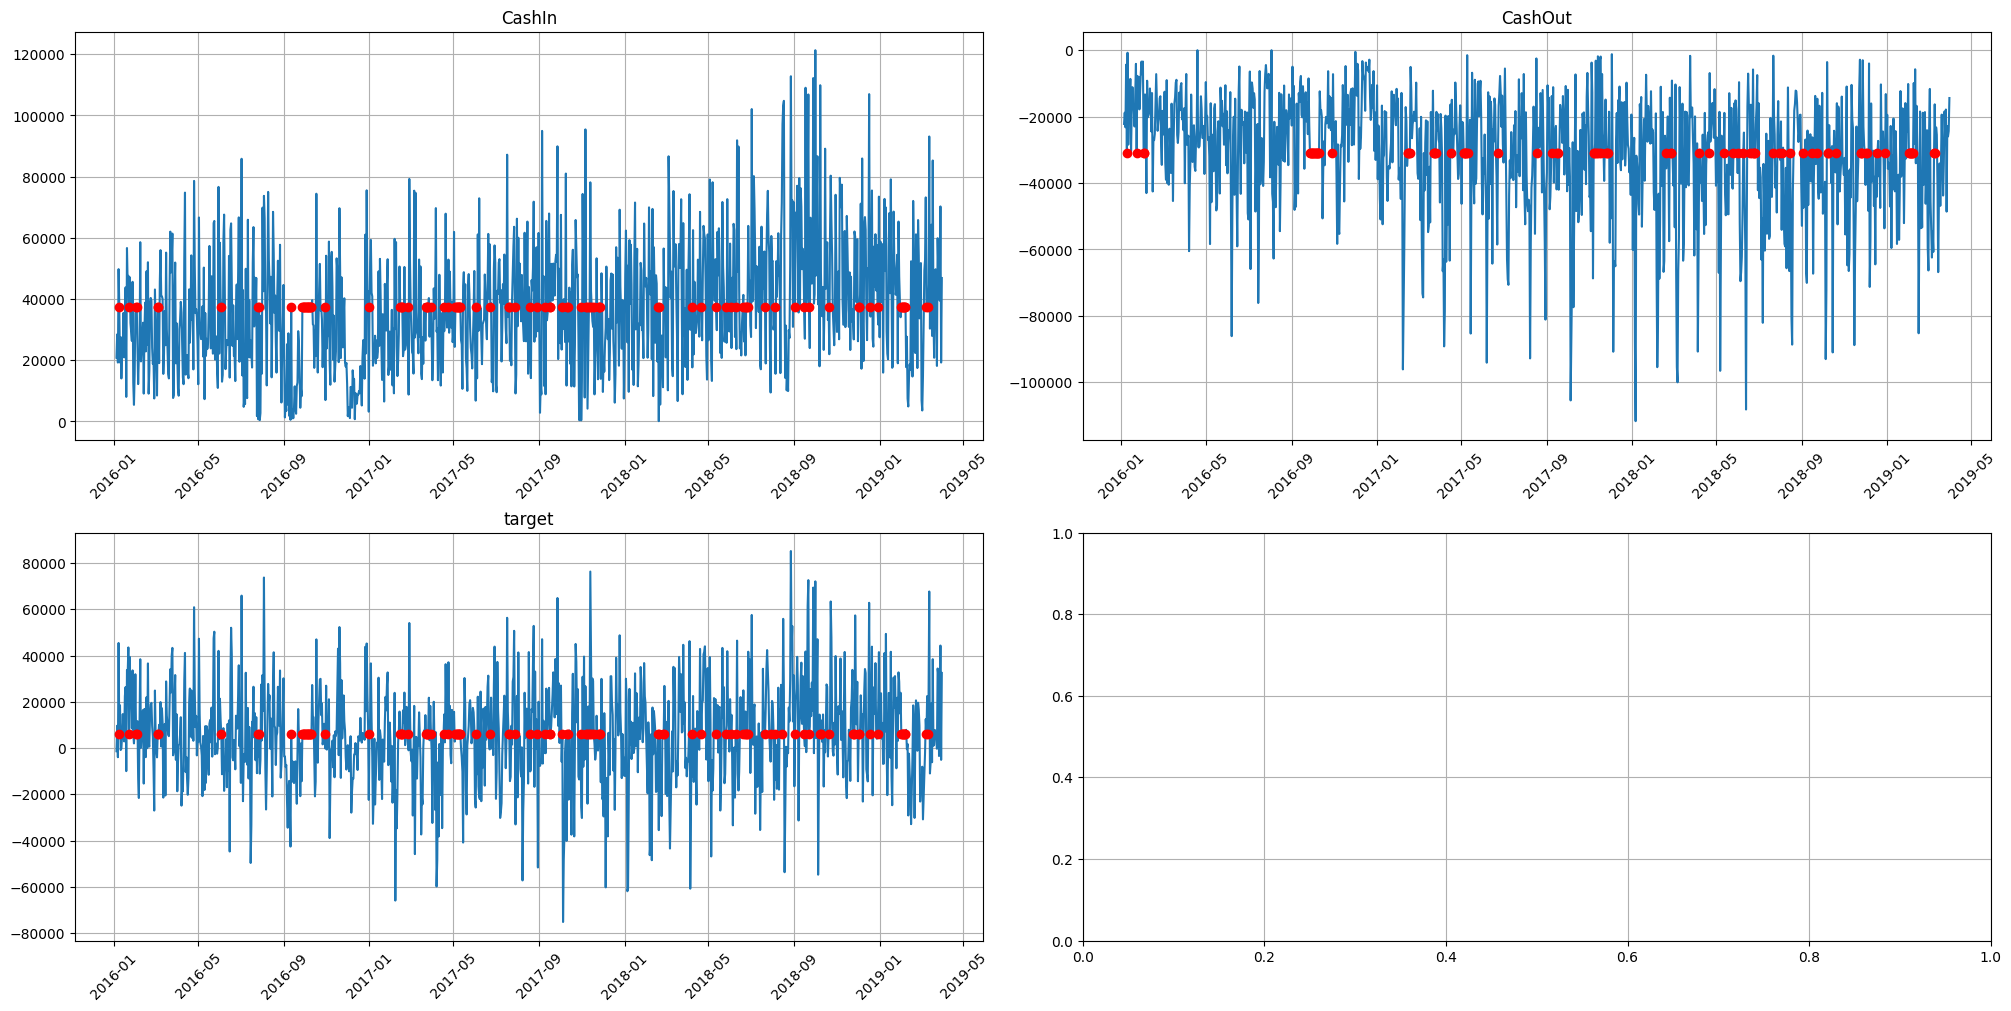

In [26]:
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="mean", window=30)
plot_imputation(imputer=outliers_imputer, ts=ts_copy)

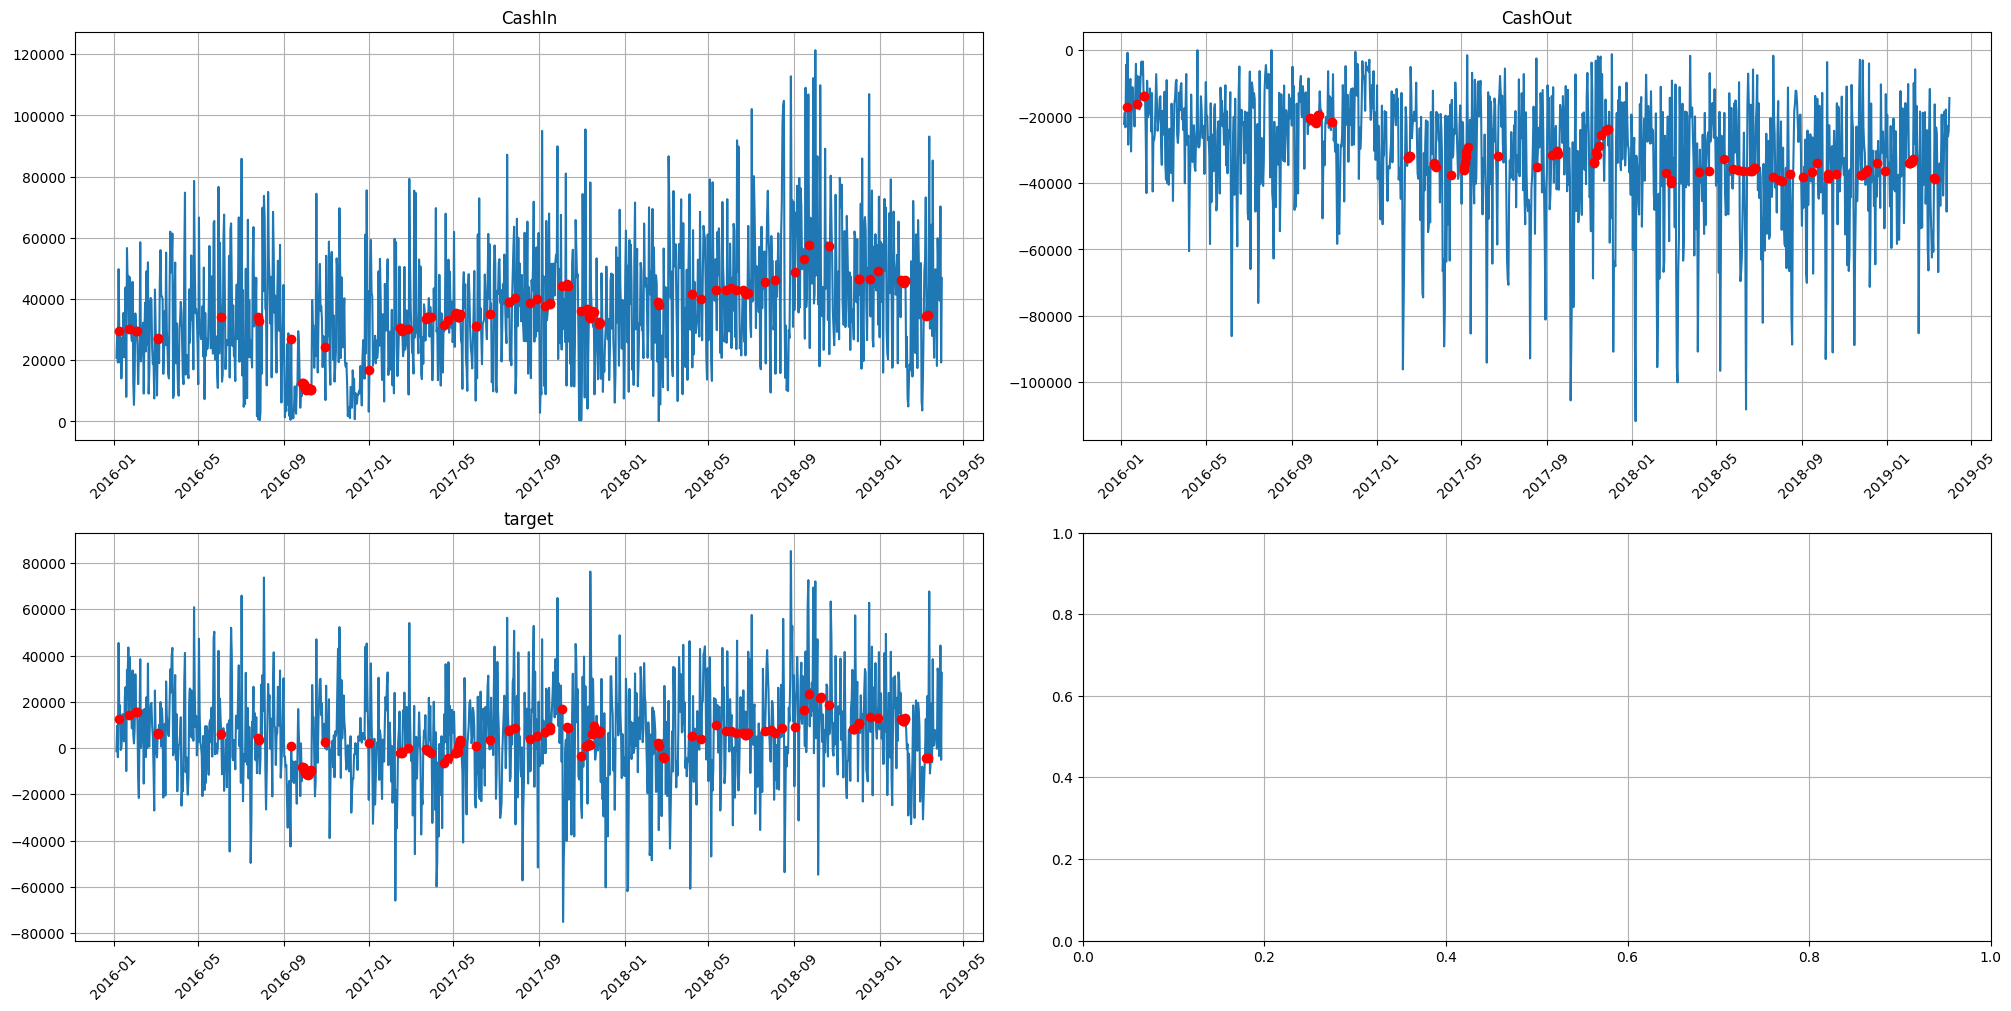

In [27]:
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
plot_imputation(imputer=outliers_imputer, ts=ts_copy)

Визуально самым адекватным кажется заполнение скользящим средним с окном в 30 дней, так как такое заполнение лучше подстраивается под внетрендовые и внесезонные (сезонность мы визуально нашли годовую) движения

In [28]:
outliers_imputer_final = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)

ts_copy.fit_transform([outliers_imputer_final])
ts_copy.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: 1D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0
target        2016-01-05    2019-03-31    1182            0


Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

Так как визуально мы обнаружили годовую сезонность, разумно будет взять за параметр окно в год

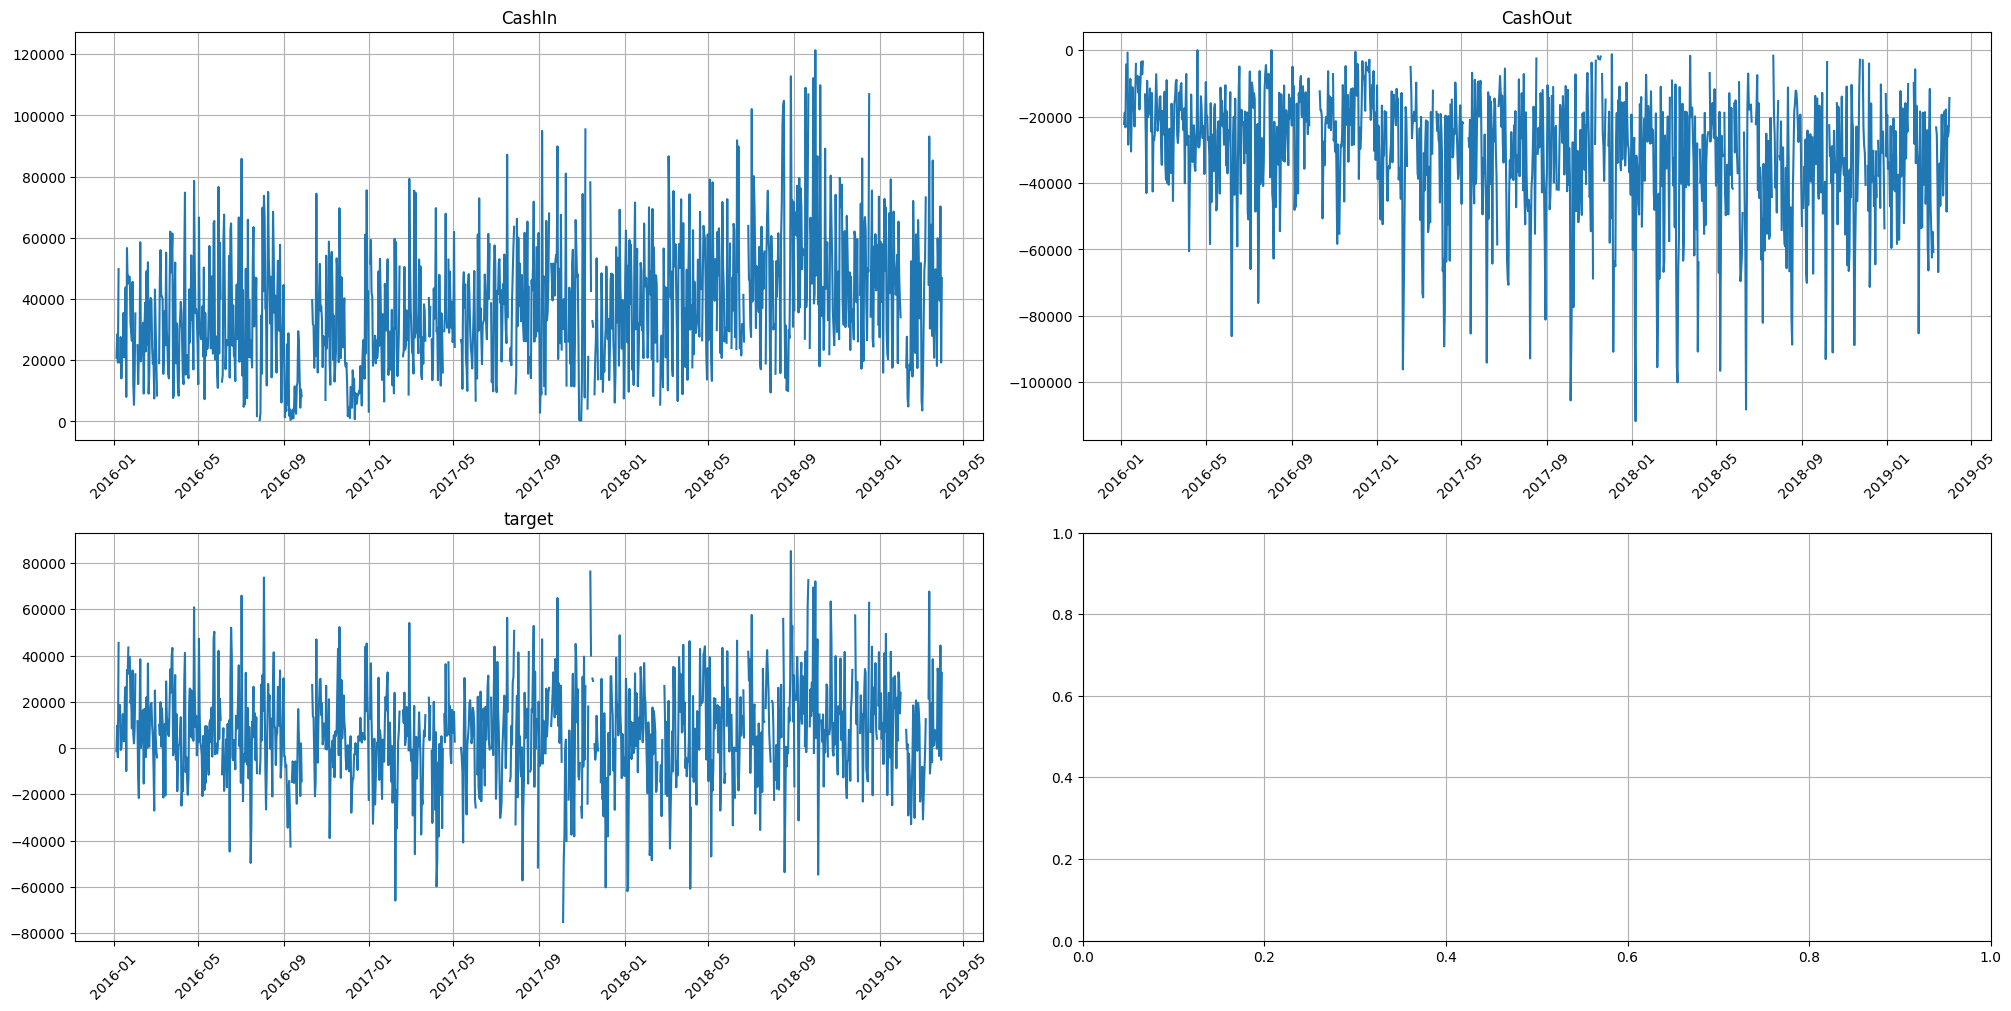

In [29]:
# проверка

anomaly_dict = get_anomalies_median(ts_plots, window_size=365, alpha=3)
plot_anomalies(ts_plots, anomaly_dict)

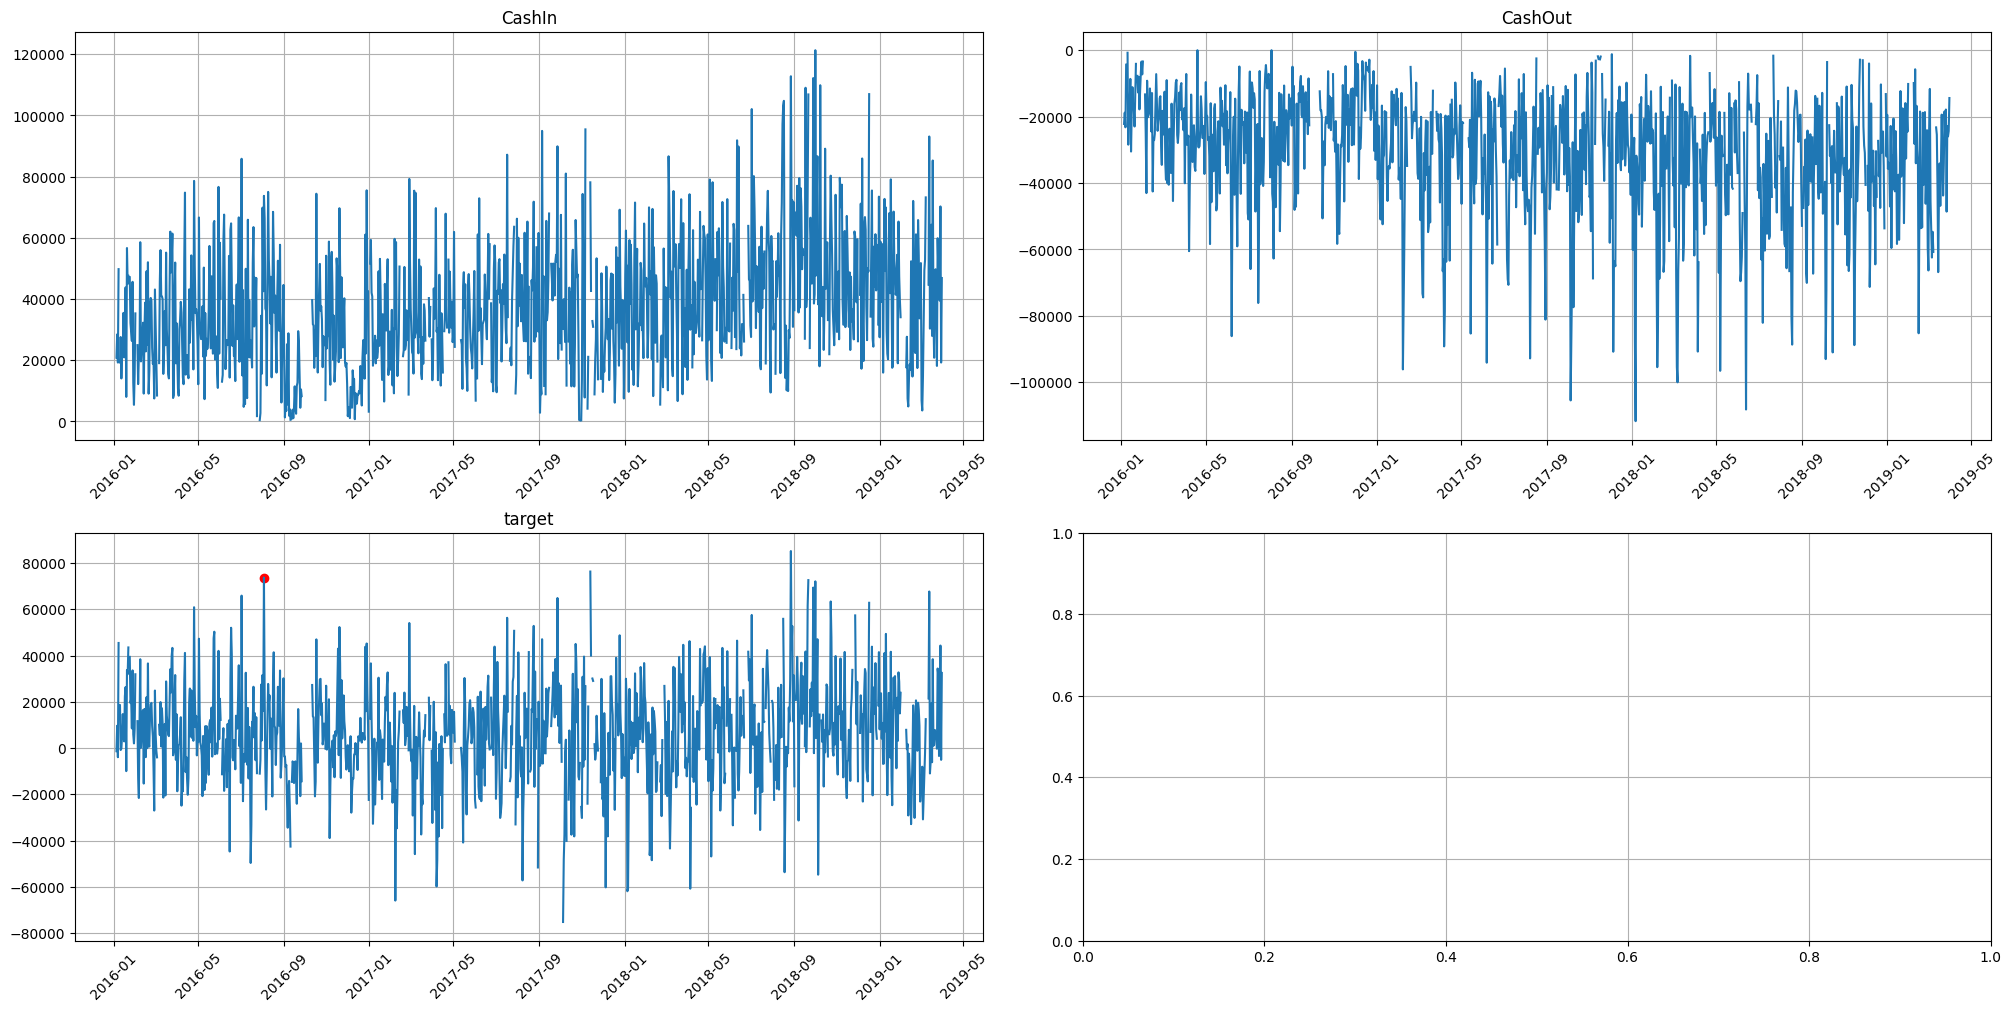

In [30]:
anomaly_dict = get_anomalies_density(ts_plots, window_size=365, distance_coef=1, n_neighbors=5)
plot_anomalies(ts_plots, anomaly_dict)

какой метод лучше? философский вопрос 

лучше тот метод, который, который приведет к лучшему качеству итоговой модели, поэтому в контексте этого задания выбрать лучший метод трудно 

выберем тот, что с плотностью - в нем затектектили меньше выбросов -  мы и так будем использовать абсолютную ошибку, выбросы нам страшны, но не очень 

выбросы заменим по той же стратегии, что и пропущенные значения 

In [31]:

#сначала заменим аутлайеры на наны, затем заполним наны 

outliers_remover = DensityOutliersTransform(in_column="target", window_size=365, distance_coef=1, n_neighbors=5)

ts_copy.fit_transform([outliers_remover])

outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)

ts_copy.fit_transform([outliers_imputer])


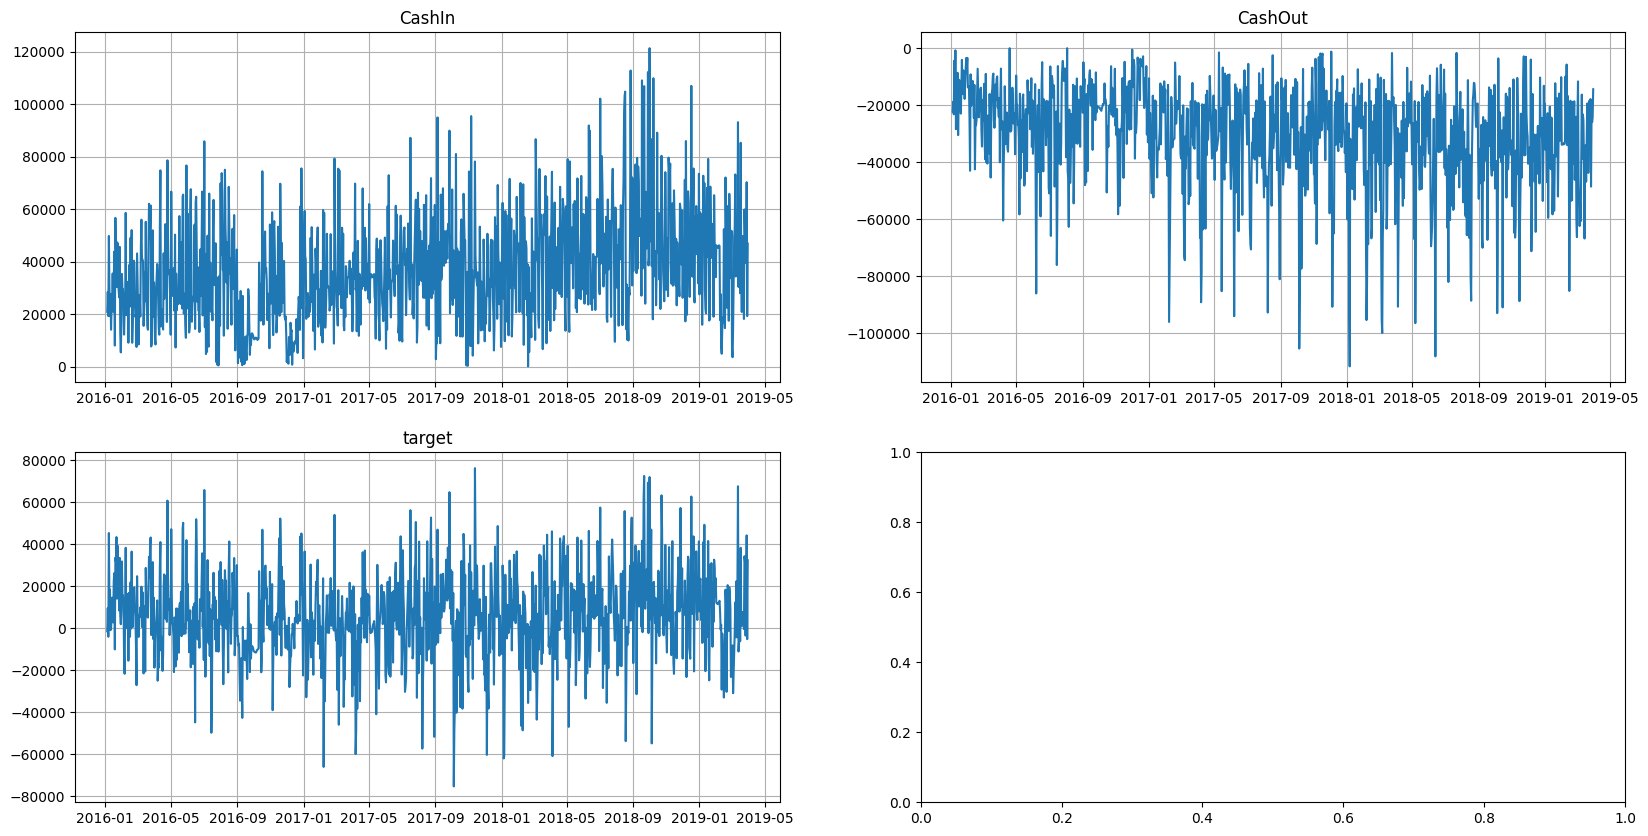

In [32]:
ts_copy.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [33]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [34]:
train_ts, test_ts = ts_copy.train_test_split(
    train_start="2016-05-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

In [35]:
horizon = 5  # горизонт предсказаний
p_model = ProphetModel(daily_seasonality=True)  # будем использовать Prophet
transforms = []  # пока оставим пустым
pipeline = Pipeline(model=p_model, transforms=transforms, horizon=horizon) 


metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts_copy, metrics=[MAE(), SMAPE()]
)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.0s finished


In [36]:
metrics_df.head(30)

segment           MAE       SMAPE  fold_number
0   CashIn  13563.395413   26.815004            0
0   CashIn  19054.671184   33.923091            1
0   CashIn  20624.621531   45.768354            2
0   CashIn   6481.214809   18.794745            3
0   CashIn  15911.511158   38.470137            4
2  CashOut  10828.990802   28.625116            0
2  CashOut  11965.928955   30.310445            1
2  CashOut   9757.739666   29.053420            2
2  CashOut  13432.415537   42.157602            3
2  CashOut  15539.591339   49.618325            4
1   target  12281.101731  154.590819            0
1   target  23483.024604  145.847930            1
1   target  13281.524593  130.663730            2
1   target  10578.129499  111.713978            3
1   target  19001.216636  129.572458            4

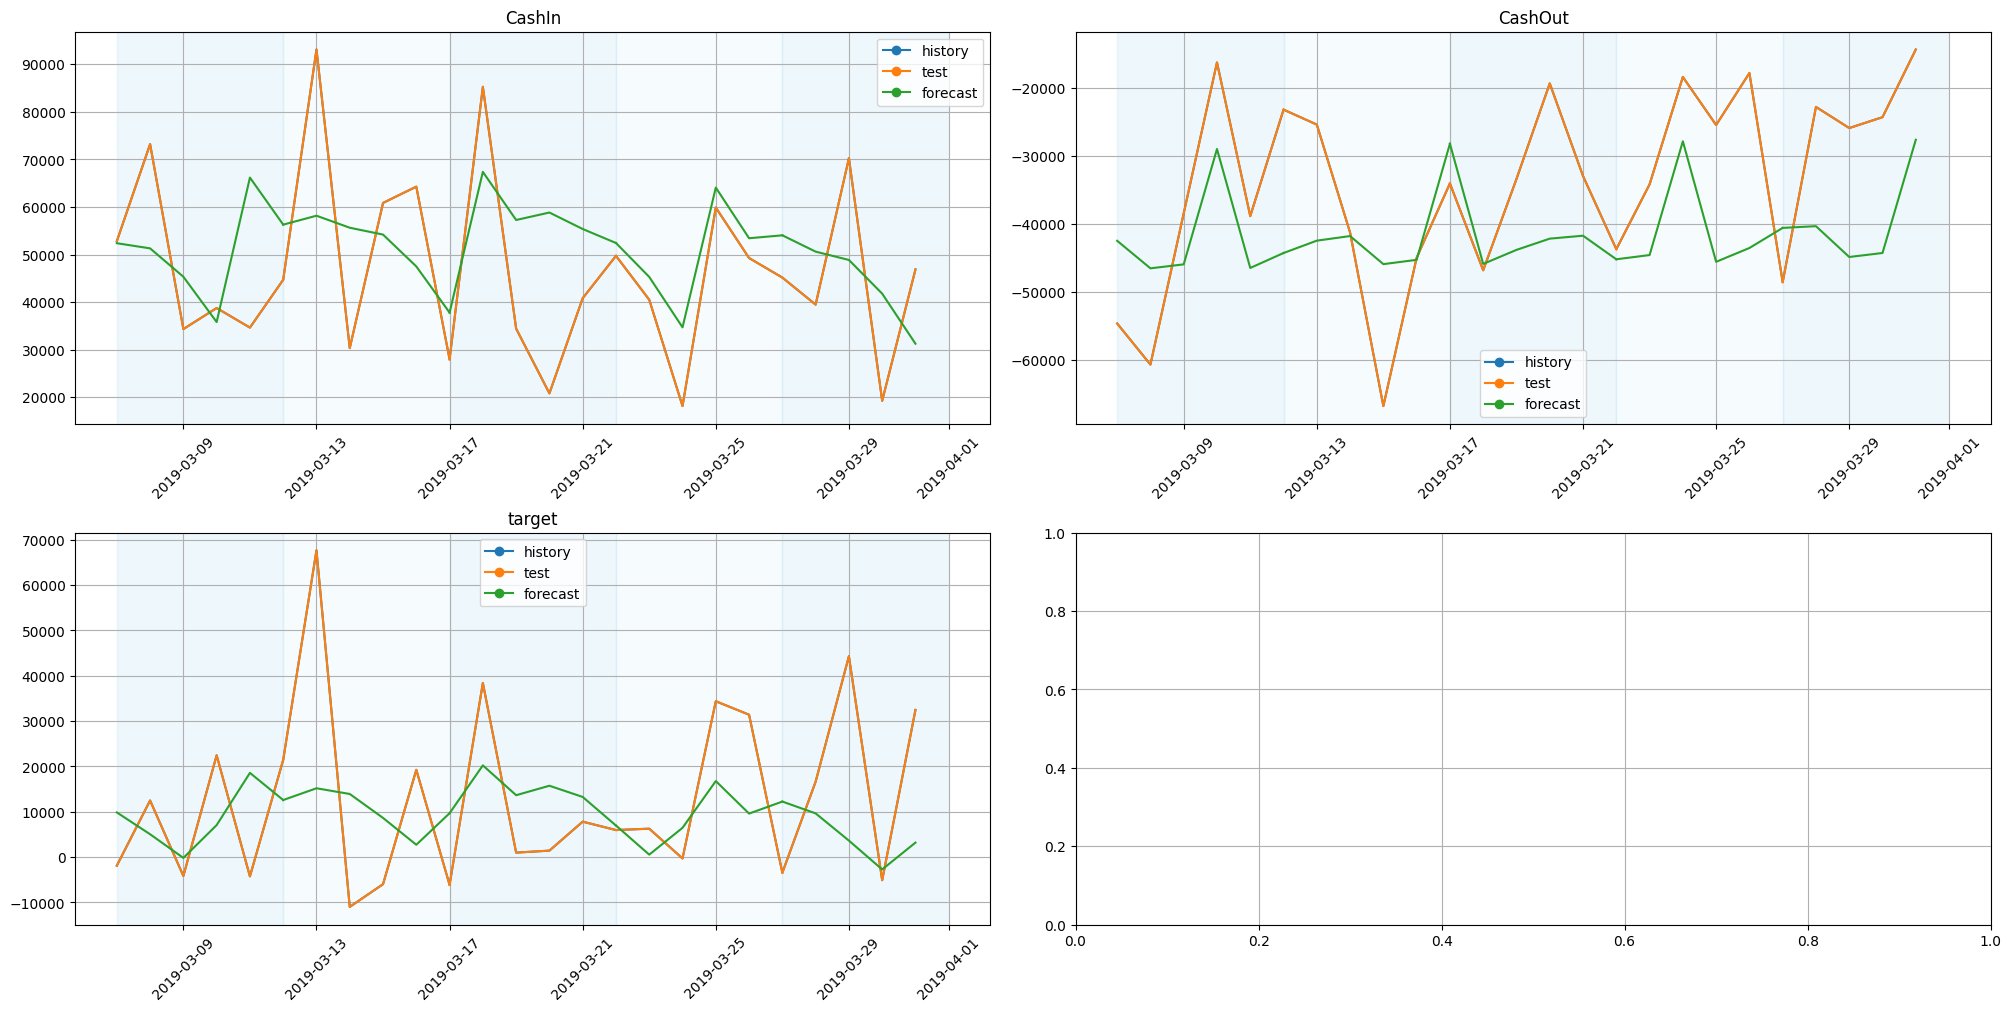

In [37]:
plot_backtest(forecast_df, ts_copy)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Для MAE уже посчитали

**CashIn:** Как для SMAPE, как и для MAE лучше всего не заглядывать слишком далеко в прошлое, но и не жить настоящим - лучше всего показывает себя CV по 3 фолду - такая же история **с балансом-таргетом**


**CashOut:** третий фолд лучше для МАЕ, первый (с далекими данными) оказался лучше для SMAPE, но разница с 3 фолдом меньше процента



### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [38]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [39]:
hierarchical_df = tds[tds['segment'] != 'target']

In [40]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)
hierarchical_df.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [41]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"total": ["CashIn", "CashOut"]}, level_names=["total", "flow_direction"]
)

hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['CashIn', 'CashOut']}, level_names = ['total', 'flow_direction'], )

In [42]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq="1D", hierarchical_structure=hierarchical_structure)
hierarchical_ts.head()


segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [43]:
hierarchical_ts.current_df_level

'flow_direction'

In [44]:
from etna.transforms import LagTransform
from etna.transforms import OneHotEncoderTransform
from etna.models import LinearPerSegmentModel
from etna.metrics import SMAPE
from etna.pipeline import HierarchicalPipeline
from etna.pipeline import Pipeline

In [45]:
reconciliator = BottomUpReconciliator(target_level="total", source_level="flow_direction")

reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [46]:
reconciliator.aggregate(ts=hierarchical_ts).head(5)

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [47]:
outliers_imputer_final = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)

hierarchical_ts.fit_transform([outliers_imputer_final])
hierarchical_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 2
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: 1D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0


In [48]:
outliers_remover = DensityOutliersTransform(in_column="target", window_size=365, distance_coef=1, n_neighbors=5)

hierarchical_ts.fit_transform([outliers_remover])

outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)

hierarchical_ts.fit_transform([outliers_imputer])

In [49]:
pipeline = HierarchicalPipeline(
    
    model=ProphetModel(daily_seasonality=True),

    reconciliator=BottomUpReconciliator(target_level="total", source_level="flow_direction"),
)

bottom_up_metrics, forecast_df, fold_info_df= pipeline.backtest(ts=hierarchical_ts, metrics=[MAE(), SMAPE()], n_folds=5)
bottom_up_metrics = bottom_up_metrics.set_index("segment").add_suffix("_bottom_up")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmicv566g/xfll_8nx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmicv566g/n872j_ay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11884', 'data', 'file=/tmp/tmpmicv566g/xfll_8nx.json', 'init=/tmp/tmpmicv566g/n872j_ay.json', 'output', 'file=/tmp/tmp768kw82f/prophet_model-20230514094750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmicv566g/myvrjfjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmicv566g/2u_1z4e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, nu

In [96]:
bottom_up_metrics.mean()

MAE_bottom_up            19099.443083
SMAPE_bottom_up            133.240178
fold_number_bottom_up        2.000000
dtype: float64

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

Автокорреляции мы уже строили в EDA, очень понравились корреляции лагов 1, 92, 182, 273,   364, их и возьмем 


На экспертном уровне добавим еще лаг месячный, так как вероятно люди получают зп с месячной периодичностью и как-то взаимодействуют с банкоматом (снимают или наоборот кладут деньги на счет, чтобы отправить родственникам)

In [51]:
ts_copy.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: 1D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0
target        2016-01-05    2019-03-31    1182            0


In [52]:
#from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
import etna.models as em 

#from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
#                        AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform, LogTransform, DateFlagsTransform, MeanTransform

In [53]:
transforms = [
    LagTransform(in_column="target", lags=list(range(92, 1, 182)), out_column="lag"),
    MeanTransform(in_column="target", window=30, out_column='mean')
]

In [80]:
pipeline_arima = Pipeline(model=em.SARIMAXModel(), transforms=transforms, horizon=5)

metrics_arima, forecast_df, _ = pipeline_arima.backtest(ts=ts_copy, metrics=[MAE(), SMAPE()], n_folds=5)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.6s finished


In [95]:
metrics_arima.mean()

MAE            23565.169821
SMAPE             86.838132
fold_number        2.000000
dtype: float64

Пока арима получше, чем иерархический ВР

In [81]:
ts_copy_2 = ts_copy
pipeline_cb_ps = Pipeline(model=em.CatBoostPerSegmentModel(), transforms=transforms, horizon=5)

metrics_catboost_ps, forecast_df, _ = pipeline_cb_ps.backtest(ts=ts_copy_2, metrics=[MAE(), SMAPE()], n_folds=5)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s finished


In [94]:
metrics_catboost_ps.mean()

MAE            16287.058372
SMAPE             72.910559
fold_number        2.000000
dtype: float64

catboost per segment тоже хуже 

In [82]:
pipeline_cb_ms = Pipeline(model=em.CatBoostMultiSegmentModel(), transforms=transforms, horizon=5)

metrics_catboost_multi, forecast_df, _ = pipeline_cb_ms.backtest(ts=ts_copy_2, metrics=[MAE(), SMAPE()], n_folds=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


In [93]:
metrics_catboost_multi.mean()

MAE            16201.817171
SMAPE             71.458139
fold_number        2.000000
dtype: float64

Пока никто не перебил иерархический ряд

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [61]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [62]:
HORIZON = 5
HISTORY_LEN = 5 * HORIZON
NUMBER_OF_LAGS = 30


model = em.CatBoostModelPerSegment()

transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts_copy_2, metrics=[SMAPE(), MAE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished


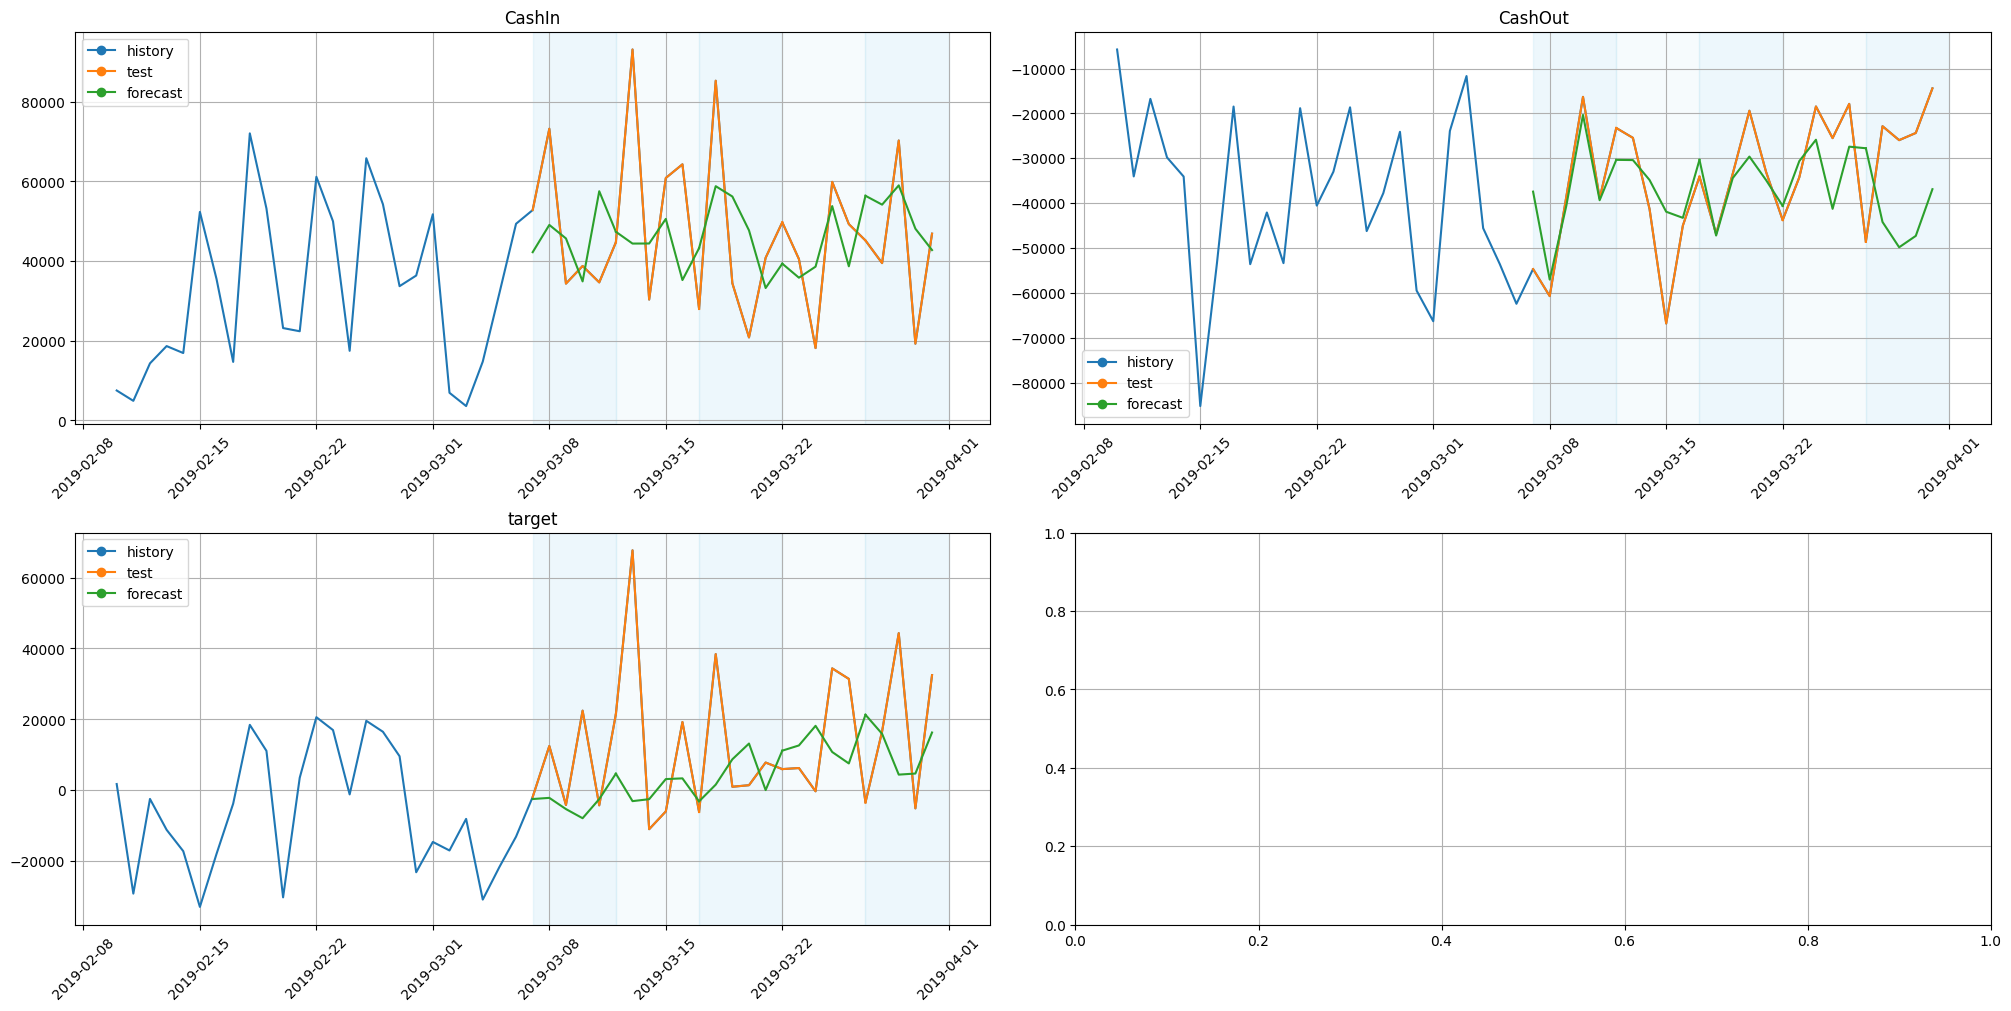

In [63]:
plot_backtest(forecast_recursive_df, ts_copy_2, history_len=HISTORY_LEN)


In [65]:
metrics_recursive_df.mean()

SMAPE             64.673983
MAE            13920.766885
fold_number        2.000000
dtype: float64

In [100]:
model = em.CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + NUMBER_OF_LAGS)),
        out_column="target_lag",
    ),
]

pipeline_direct = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

metrics_direct_pipeline_df, forecast_pipeline_df, _ = pipeline_direct.backtest(
    ts=ts_copy, metrics=[SMAPE(), MAE()]
)

direct_pipeline_metrics = metrics_direct_pipeline_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished


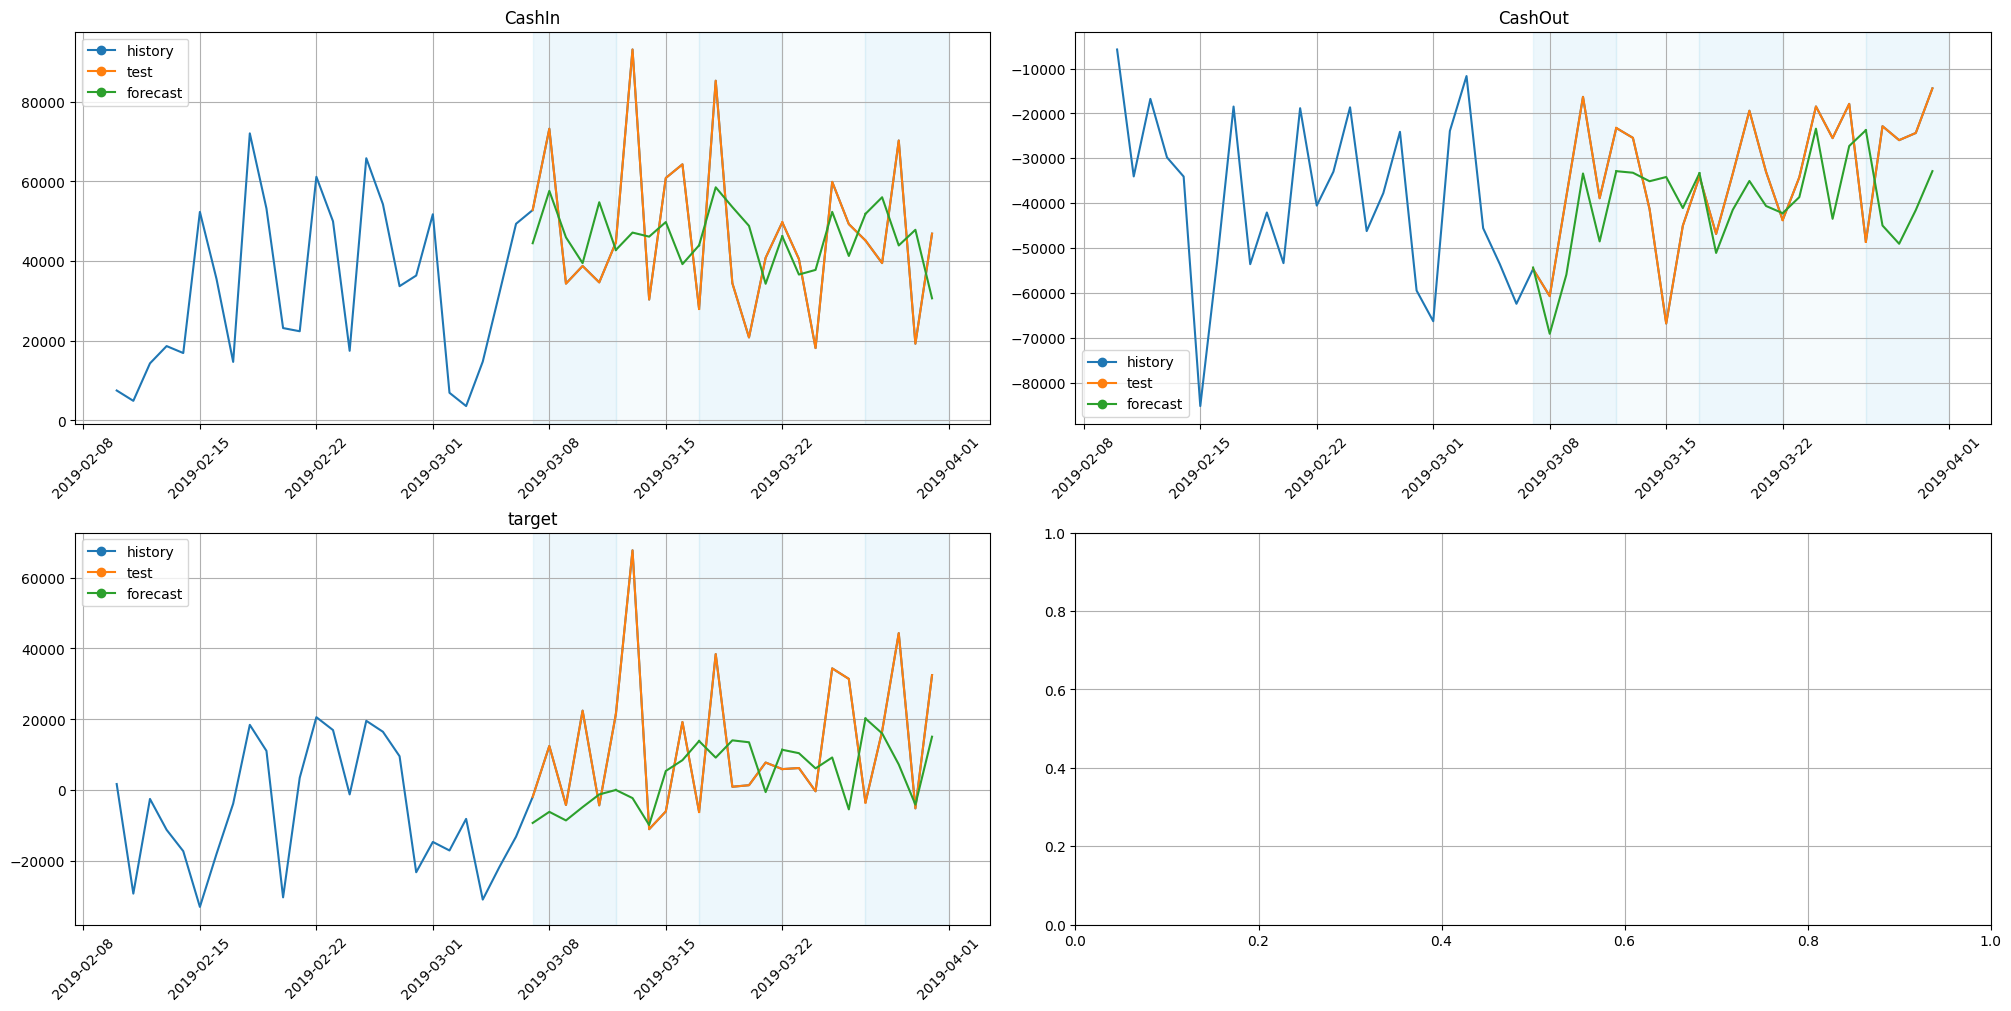

In [67]:
plot_backtest(forecast_pipeline_df, ts_copy_2, history_len=HISTORY_LEN)


In [68]:
direct_pipeline_metrics

SMAPE             67.368526
MAE            14648.115563
fold_number        2.000000
dtype: float64

In [102]:
horizons = [5, 14]

model_1 = em.CatBoostModelPerSegment()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = em.CatBoostModelPerSegment()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])


pipeline_direct_ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = pipeline_direct_ensemble.backtest(
    ts=ts_copy_2, metrics=[SMAPE(), MAE()]
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.

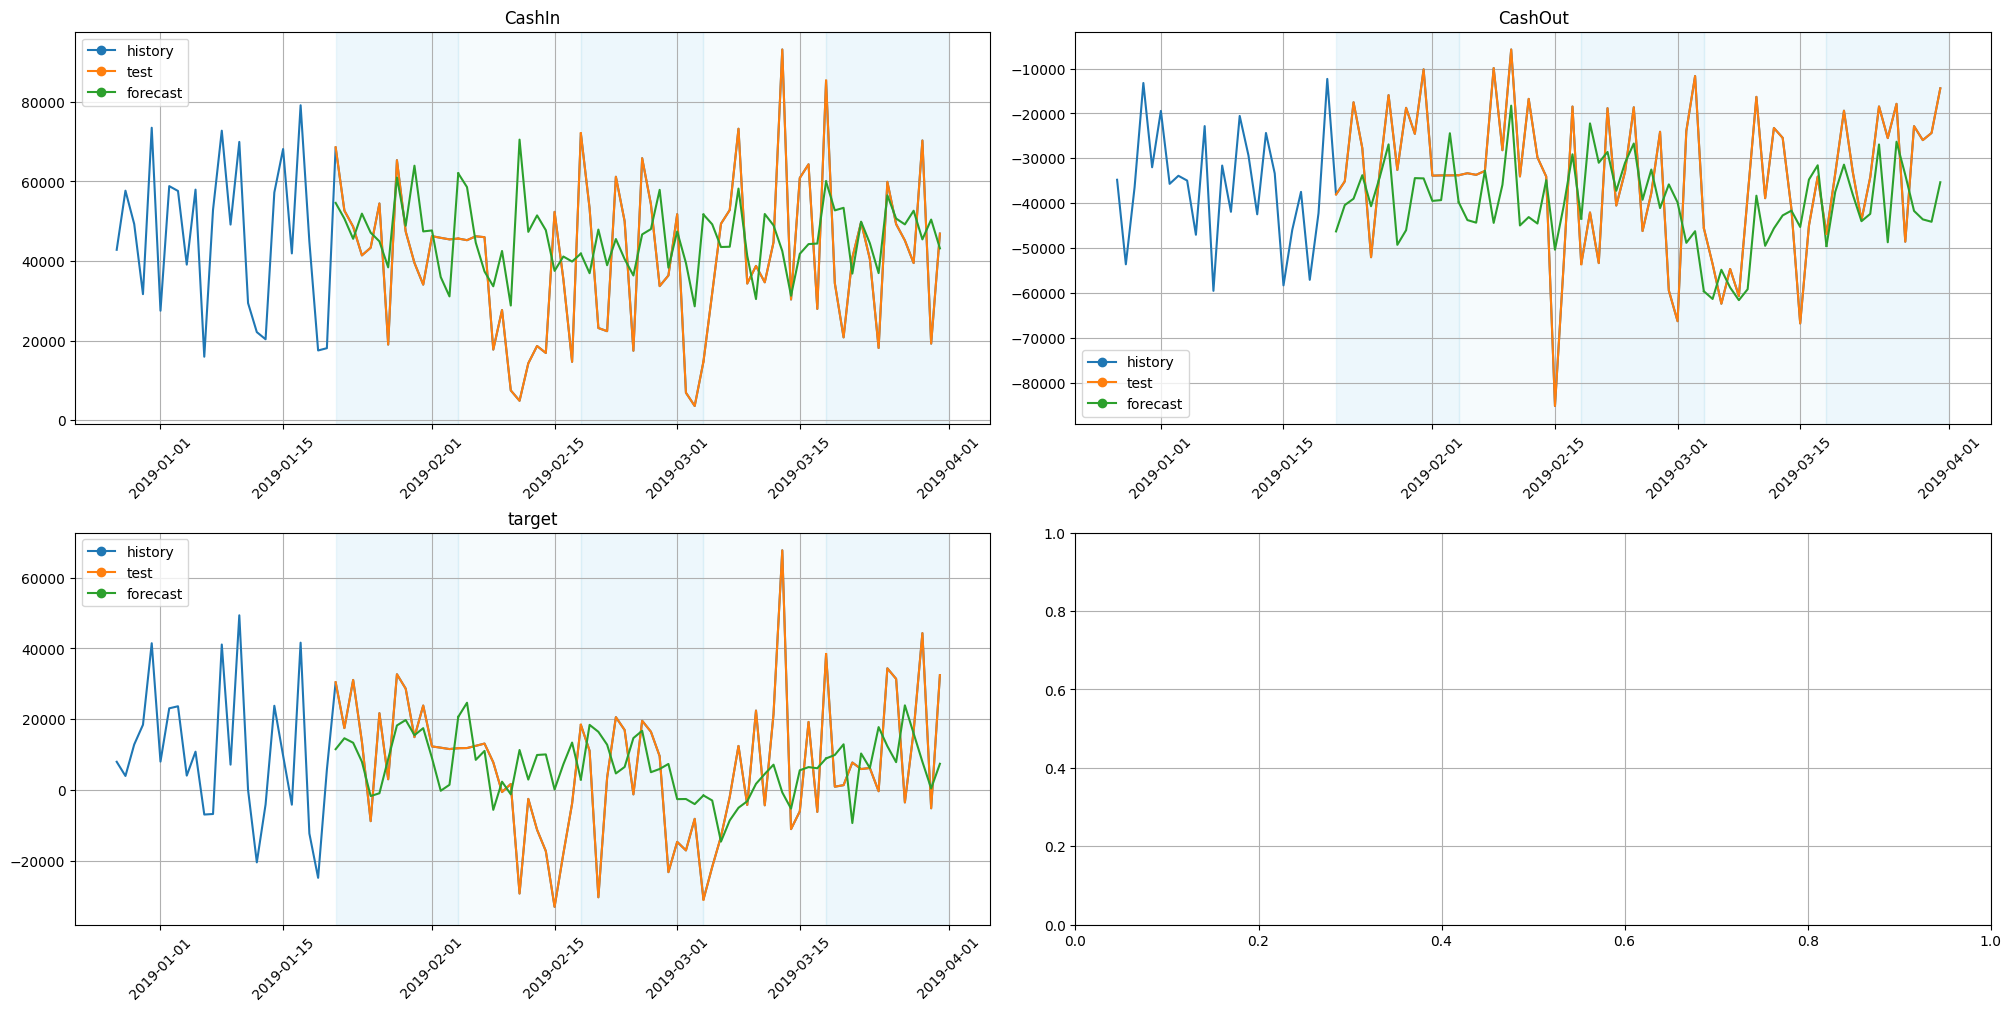

In [70]:
plot_backtest(forecast_ensemble_df, ts_copy_2, history_len=HISTORY_LEN)

In [71]:
ensemble_metrics

SMAPE             68.087571
MAE            14280.443507
fold_number        2.000000
dtype: float64

Лучшей оказалась комбинация CatBoostModelPerSegment и рекурсивной стратегии

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [104]:
#попытка раз, используем пайплайны с лагами 
pipeline_names = ["arima", "cb_per_segment", "cb_ms"]
pipelines = [pipeline_arima, pipeline_cb_ps, pipeline_cb_ms]


voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 8, 9], n_jobs=2)
voting_ensamble_metrics, _, _ = voting_ensemble.backtest(
    ts=ts_copy_2,
    metrics=[MAE(),  SMAPE()],
    n_folds=5,
    n_jobs=2
)


[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   19.7s finished
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   20.2s finished
[Parallel(n_jobs=2)]: Using backend SequentialBacke

In [98]:
voting_ensamble_metrics.mean()

MAE            15846.383162
SMAPE             71.764893
fold_number        2.000000
dtype: float64

пока вышло не очень, ансамбль показал себя не лучше чем лучшая модель 

In [105]:
#попытка 2, используем стратегии прогнозирования
pipeline_names = ["autoregressivepipeline", "pipeline_direct"]
pipelines = [autoregressivepipeline, pipeline_direct]


voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[4, 3], n_jobs=2)
voting_ensamble_metrics, _, _ = voting_ensemble.backtest(
    ts=ts_copy_2,
    metrics=[MAE(),  SMAPE()],
    n_folds=5,
    n_jobs=2
)


[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   59.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   59.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapse

In [106]:
voting_ensamble_metrics.mean()

MAE            14095.845706
SMAPE             67.947349
fold_number        2.000000
dtype: float64

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

это фашизм так никогда не было!!!111

In [ ]:
#YOUR CODE HERE#